In [1]:
import warnings
warnings.filterwarnings('ignore')
# There are some warnings that tell us about future deprecation
# These are important to see at least once to help future proof our code
# Ignoring them outright is a bad practice
# However, we also don't want to be spammed by them 
# Usually we might do warnings.filterwarnings(action='once')
# Unfortunately this wouldn't work with the libraries we are using

In [2]:
!pip install -qq transformers
!pip install watermark
!pip install gdown

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.2
    Uninstalling importlib-metadata-4.8.2:
      Successfully uninstalled importlib-metadata-4.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.
gym 0.21.0 requires importlib-metadata>=4.8.1; python_version < "3.8", but you have importlib-metadata 2.1.3 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=f2ef1e9543ee4ce59e3e4f23df5454854d0523117294ce96c5d07899d189c68d
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0

In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers
# ipython magic for checking the latest updated versions

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.29.0

numpy       : 1.19.5
pandas      : 1.3.4
torch       : 1.9.1
transformers: 4.12.5



In [4]:
# Imports and setup
import transformers  # Huggingface is AWESOME!
from transformers import (
    BertModel, 
    BertTokenizer, 
    AdamW, 
    get_linear_schedule_with_warmup
)
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
# Configure Ipy's backend to use retina display mode
%config InlineBackend.figure_format="retina"

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = [
  "#01BEFE", 
  "#FFDD00", 
  "#FF7D00", 
  "#FF006D", 
  "#ADFF02", 
  "#8F00FF"
]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Now we init a seed from numpy
# So we can have the same result
# Everytime we run this file
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# This line will select a CUDA GPU if available
# If not computation will occur on the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Setup Complete!")

Setup Complete!


We're gonna use the Google Play App reviews dataset

In [5]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /kaggle/working/apps.csv
100%|████████████████████████████████████████| 134k/134k [00:00<00:00, 71.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /kaggle/working/reviews.csv
100%|███████████████████████████████████████| 7.17M/7.17M [00:00<00:00, 202MB/s]


In [6]:
df = pd.read_csv("reviews.csv")
df.head()
# DF usually refers to dataframe, a pandas type

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [7]:
# We can see the format of the data above
# Now let's check the shape of the data structure
df.shape

(15746, 11)

In [8]:
# Roughly 16k examples.
# Let's check for missing data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Text(0.5, 0, 'Review Score')

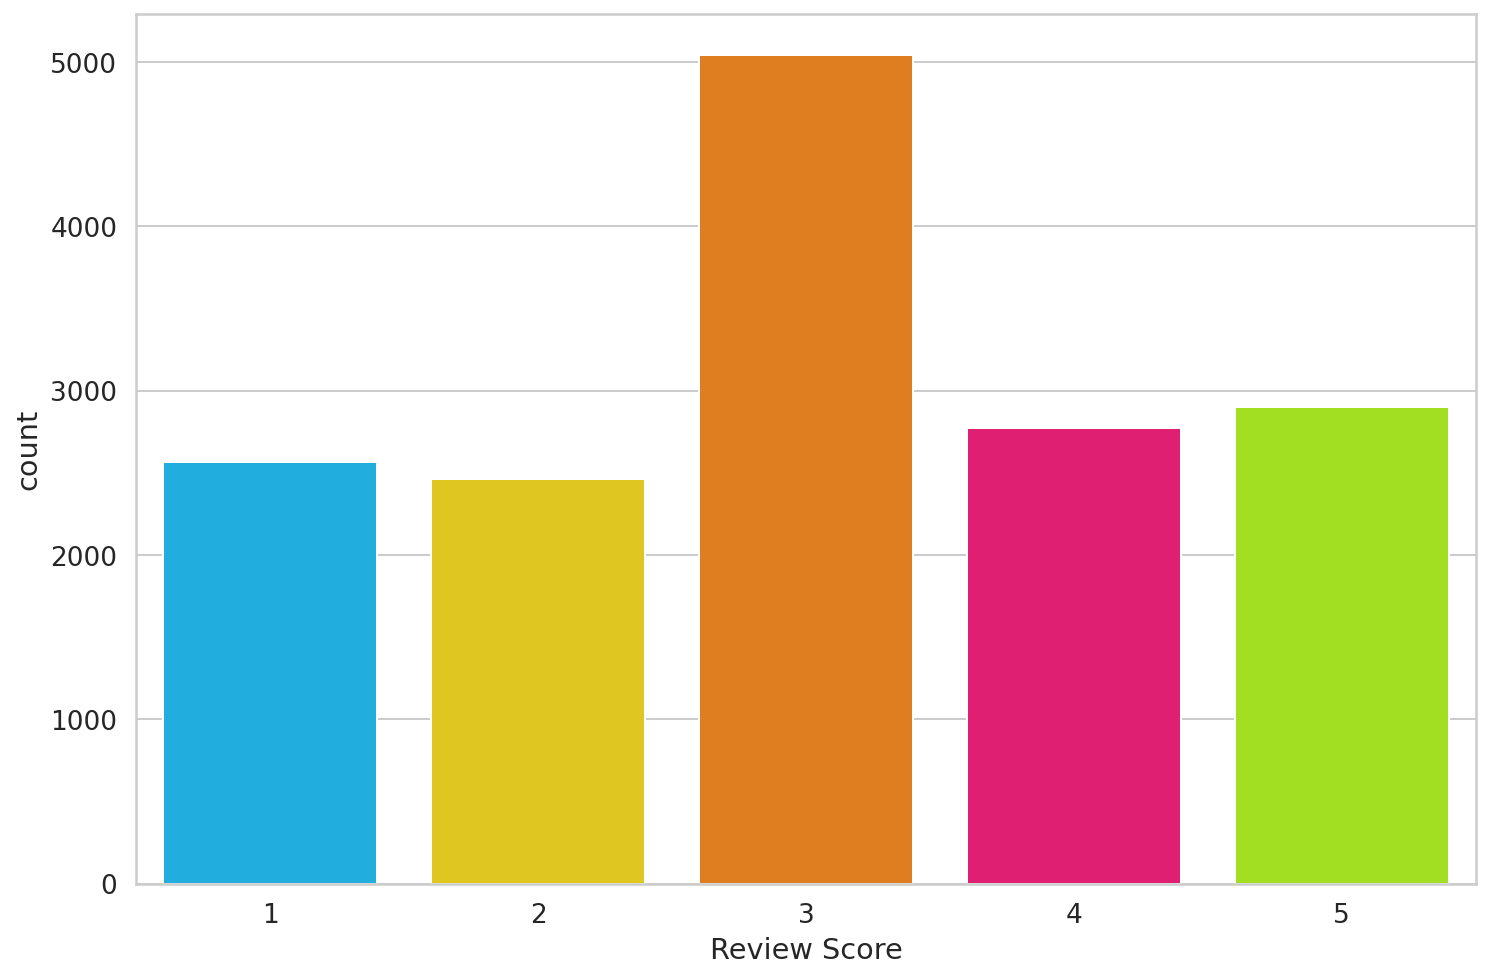

In [9]:
# We have no missing values in the score and review texts
# We'll check for class imbalance now
sns.countplot(df.score)
plt.xlabel("Review Score")

[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

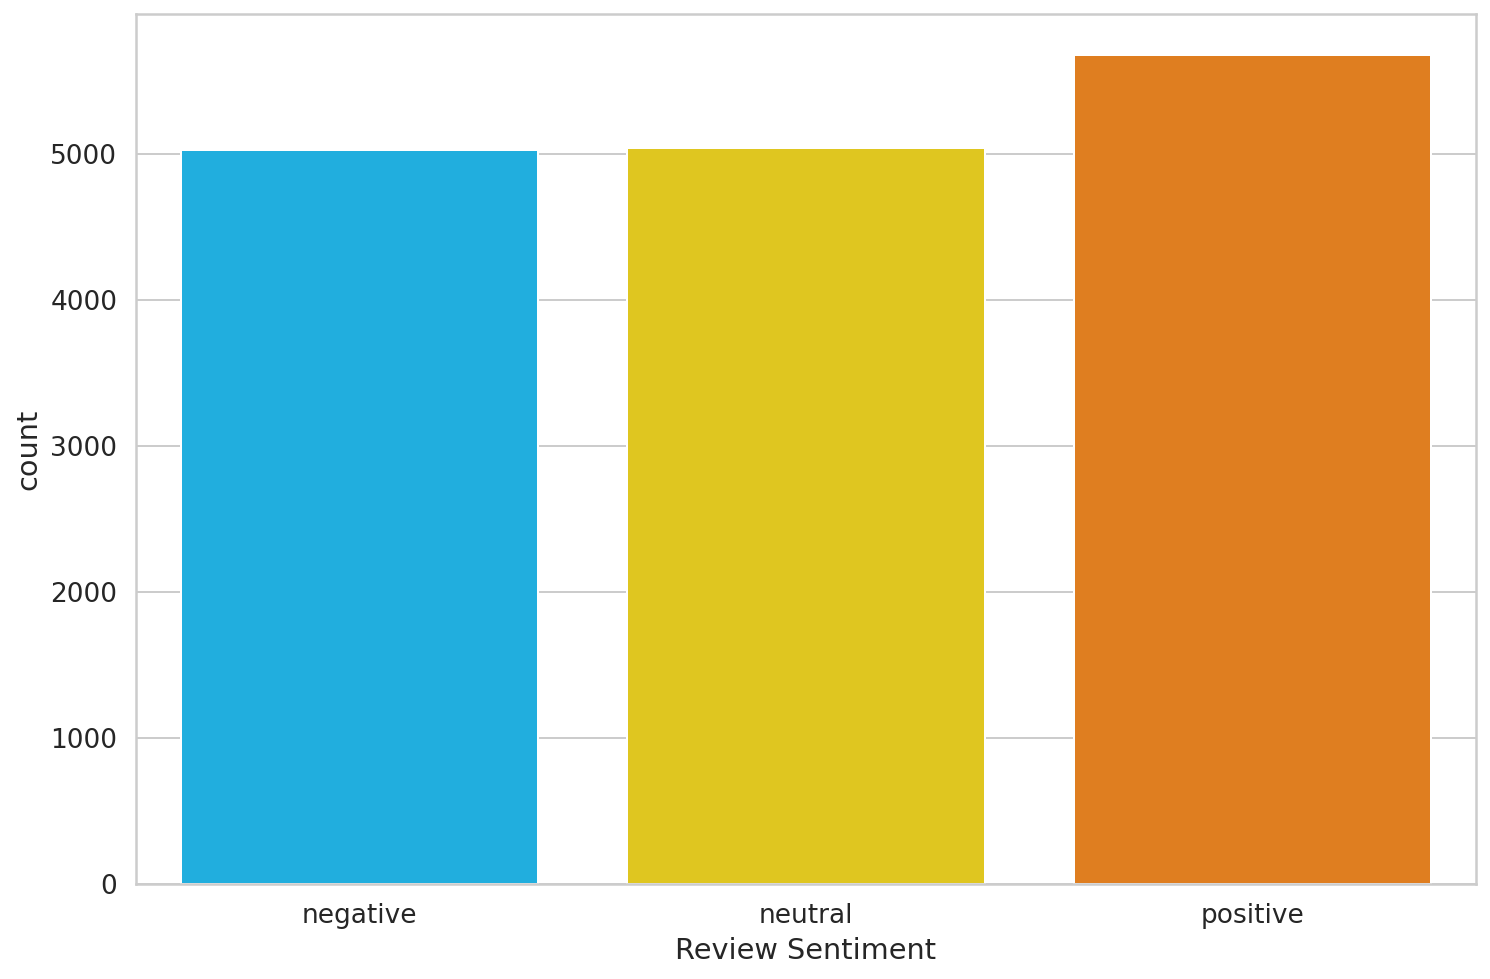

In [10]:
# We see a massive imbalance here
# We're gonna combat this by converting the dataset into negative, neutral
# And positive sentiments:

# This function is essentially a clamper
def to_sentiment(rating):
  rating = int(rating)  # casting to int
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(x=df.sentiment)
plt.xlabel("Review Sentiment")
ax.set_xticklabels(class_names)

While it's still not ideal, the balance is mostly restored.

Our next focus is preprocessing the data to be usable.

In the case of BERT, we need to add special tokens to separate sentences and do classification, pass sequences of constant length (introduce padding), create array of 0s (pad token) and 1s (real token) called an attention mask.

In [11]:
PRE_TRAINED_MODEL_NAME =  'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Example to understand tokenization
sample = "When was I last outside? I have been stuck at home for 2 weeks."

tokens = tokenizer.tokenize(sample)
# Convert the tokens to unique int ids
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f"Sentence: {sample}")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Sentence: When was I last outside? I have been stuck at home for 2 weeks.
Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'have', 'been', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1138, 1151, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [12]:
# [SEP] is a marker for the end of a sentence
# [CLS] is a token to add at the start of a sentence.
# This allows BERT to know we're doing classification
# [PAD] is a padding token
# Everything else can be encoded with [UNK] - Unknown token

print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [13]:
# We can do all this with the following method
encoding = tokenizer.encode_plus(
    sample,
    truncation=True,
    max_length=32,  # The most is 512 for BERT
    add_special_tokens=True,  # Adds [CLS] and [SEP]
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'  # Returns PyTorch Tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [14]:
# The token ids are now stored in a tensor and padded to len=32

print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1138, 1151, 5342, 1120,
        1313, 1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [15]:
# The attention mask has the same length
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [16]:
# We can inverse the tokenization to look at the special tokens
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'have',
 'been',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Text(0.5, 0, 'Token Count')

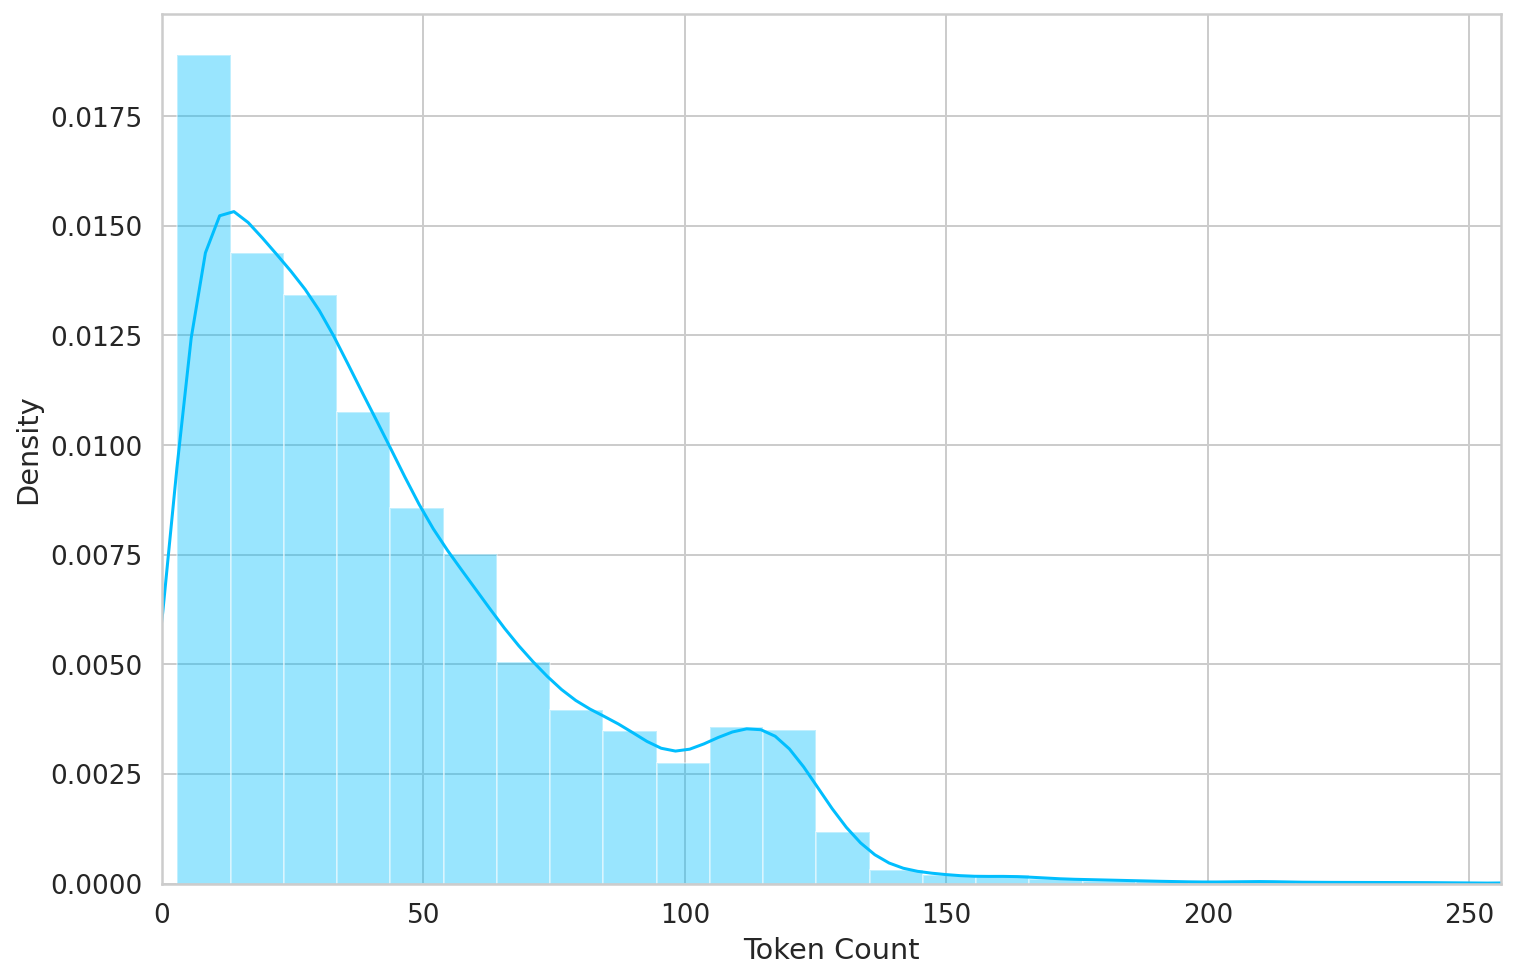

In [17]:
# BERT works with fixed-length sequences
# We'll choose the max length and store token length for each review

token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, truncation=True, max_length=512)
  token_lens.append(len(tokens))

# And then we plot the distribution
sns.distplot(x=token_lens)
plt.xlim([0, 256])
plt.xlabel('Token Count')

In [18]:
# Most of the reviews seem to contain less than 128 tokens
# To be safe we will take 160 as the max length

MAX_LEN = 160

In [19]:
# Using all of this knowledge, we can build a PyTorch dataset

class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        truncation=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'review_text': review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
    }

In [20]:
# The tokenizer does most of the work
# We also return review texts, so it'l be easier to evaluate the predictions
# Now, we split the data

df_train, df_test = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
    df_test,
    test_size = 0.5,
    random_state=RANDOM_SEED
)

df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [21]:
# We need a couple of data loader methods

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      reviews=df.content.to_numpy(),
      targets=df.sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=2
  )

BATCH_SIZE = 16

# Creating the loaders for each df split
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

print("All done!")

All done!


In [22]:
# Let's have a look at an example batch from the training data loader:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [23]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


Now we finally start working on the actual model.

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use BertForSequenceClassification, BertForQuestionAnswering or something else. In this case we're going to stick to the basic BertModel and build our sentiment classifier on top of it.

In [24]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
# Try and use it on our sample text's encoding.
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask'],
    return_dict = False   # this is needed to get a tensor as result
    # This is due to new versions of HuggingFace
)
# The last_hidden_state is a sequence of hidden states 
# of the last layer of the model.

In [26]:
# Obtaining the pooled_output is done by applying the 
# BertPooler on last_hidden_state:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [27]:
# 768 corresponds to the number of hidden units in the 
# feed-forward networks.
bert_model.config.hidden_size
# Should tally

768

In [28]:
# The pooled_output is a summary of the content according to BERT
pooled_output.shape

torch.Size([1, 768])

In [29]:
# Let's now create a classifier class using BERT
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    # The class needs to initialize itself first
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  # Forward pass
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict=False  # Needed to get Tensor output instead of string
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [30]:
# The BertModel is handling most of the work
# We use a dropout layer for regularization 
# And a fully-connected layer for output
# The output of the last layer is raw, this is needed for cross entropy loss
# Now we create an instance and move it to the GPU
model = SentimentClassifier(len(class_names))
model = model.to(device)  # From setup

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
# Move the example batch of training data to the GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)  # Batch size x seq length
print(attention_mask.shape)  # Batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [32]:
# To get the probabilities from the trained model, we can apply softmax

F.softmax(model(input_ids, attention_mask), dim=1)  # 1 dimension

tensor([[0.2332, 0.4717, 0.2951],
        [0.2219, 0.3612, 0.4168],
        [0.3589, 0.2427, 0.3984],
        [0.2221, 0.3218, 0.4561],
        [0.5762, 0.2056, 0.2181],
        [0.2249, 0.4422, 0.3329],
        [0.2750, 0.3181, 0.4069],
        [0.3732, 0.2454, 0.3813],
        [0.3927, 0.1892, 0.4181],
        [0.3349, 0.1948, 0.4703],
        [0.3043, 0.2263, 0.4695],
        [0.3710, 0.1894, 0.4396],
        [0.2090, 0.4449, 0.3462],
        [0.3396, 0.2594, 0.4010],
        [0.3456, 0.2260, 0.4284],
        [0.1500, 0.3302, 0.5198]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [33]:
# To reproduce the training procedure from the BERT paper we'll use
# the AdamW optimizer provided by HuggingFace. It corrects weight decay.
# We'll also use a linear scheduler with no warmup steps
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

The authors of the original BERT paper have some recommendations for hyperparameter finetuning.
Batch size 16, 32, learning rate (Adam): 5e-5, 3e-5, 2e-5, number of epochs: 2, 3, 4. <br>
In this case we've ignored the epoch recommendation but we're sticking with the rest

In [34]:
# Let's create a helper function for training one epoch
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

# The training procedure should look familiar. The scheduler gets called
# every time a batch is fed to the model. We're avoiding exploding gradients
# by clipping the gradients of the model with clip_grad_norm

In [35]:
# Let's write another helper to help us evaluate the model on a given dataloader
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [36]:
%%time
# Using these two, we can write our training loop and store training history

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )

  print(f'Train loss {train_loss} Accuracy: {train_acc}')

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )

  print(f'Val loss {val_loss} Accuracy: {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7263235386048967 Accuracy: 0.6768753087290946
Val loss 0.5857373604178429 Accuracy: 0.770012706480305

Epoch 2/10
----------
Train loss 0.41761922545344243 Accuracy: 0.8417895702491003
Val loss 0.5707353942096234 Accuracy: 0.8170266836086404

Epoch 3/10
----------
Train loss 0.2394875260380057 Accuracy: 0.9222355514783713
Val loss 0.6238766274321824 Accuracy: 0.8602287166454893

Epoch 4/10
----------
Train loss 0.1536113029110937 Accuracy: 0.953919977418672
Val loss 0.7206238090223632 Accuracy: 0.8564167725540026

Epoch 5/10
----------
Train loss 0.11069121323504882 Accuracy: 0.9672570743066827
Val loss 0.7823254084098152 Accuracy: 0.8614993646759848

Epoch 6/10
----------
Train loss 0.0819273405662976 Accuracy: 0.9771364053348388
Val loss 0.828658182801446 Accuracy: 0.866581956797967

Epoch 7/10
----------
Train loss 0.061268924792150285 Accuracy: 0.980947004445699
Val loss 0.8705089365958701 Accuracy: 0.8703939008894537

Epoch 8/10
----------
Train 

(0.0, 1.0)

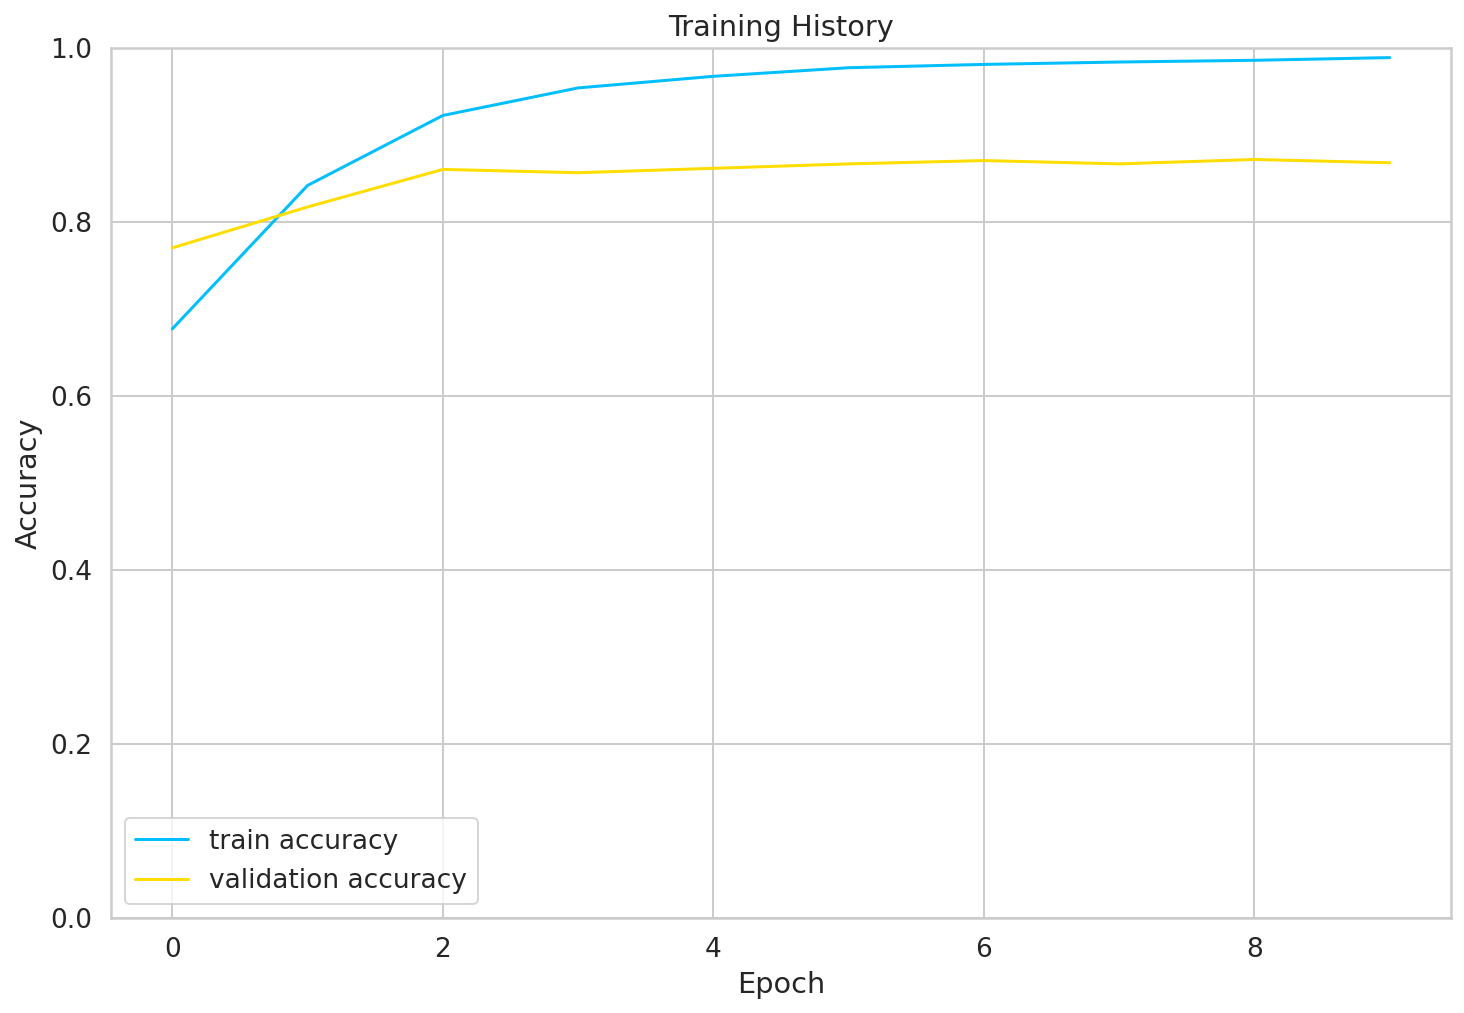

In [37]:
# Now we can check the training vs validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [38]:
# More parameter finetuning can be done but we will proceed with this
# Let's calculate the accuracy on test data split
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

test_acc.item()

0.8908629441624365

In [39]:
# The accuracy is a bit higher; the model seems to generalize well.
# We'll define a helper function to get predictions from the model:

def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts= []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()    
    return review_texts, predictions, prediction_probs, real_values

In [40]:
# This would be similar to the eval function except we're storing the text of the
# reviews and the predicted probabilities

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [41]:
# Let's have a look at the classification report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.93      0.86      0.89       245
     neutral       0.82      0.88      0.85       254
    positive       0.93      0.93      0.93       289

    accuracy                           0.89       788
   macro avg       0.89      0.89      0.89       788
weighted avg       0.89      0.89      0.89       788



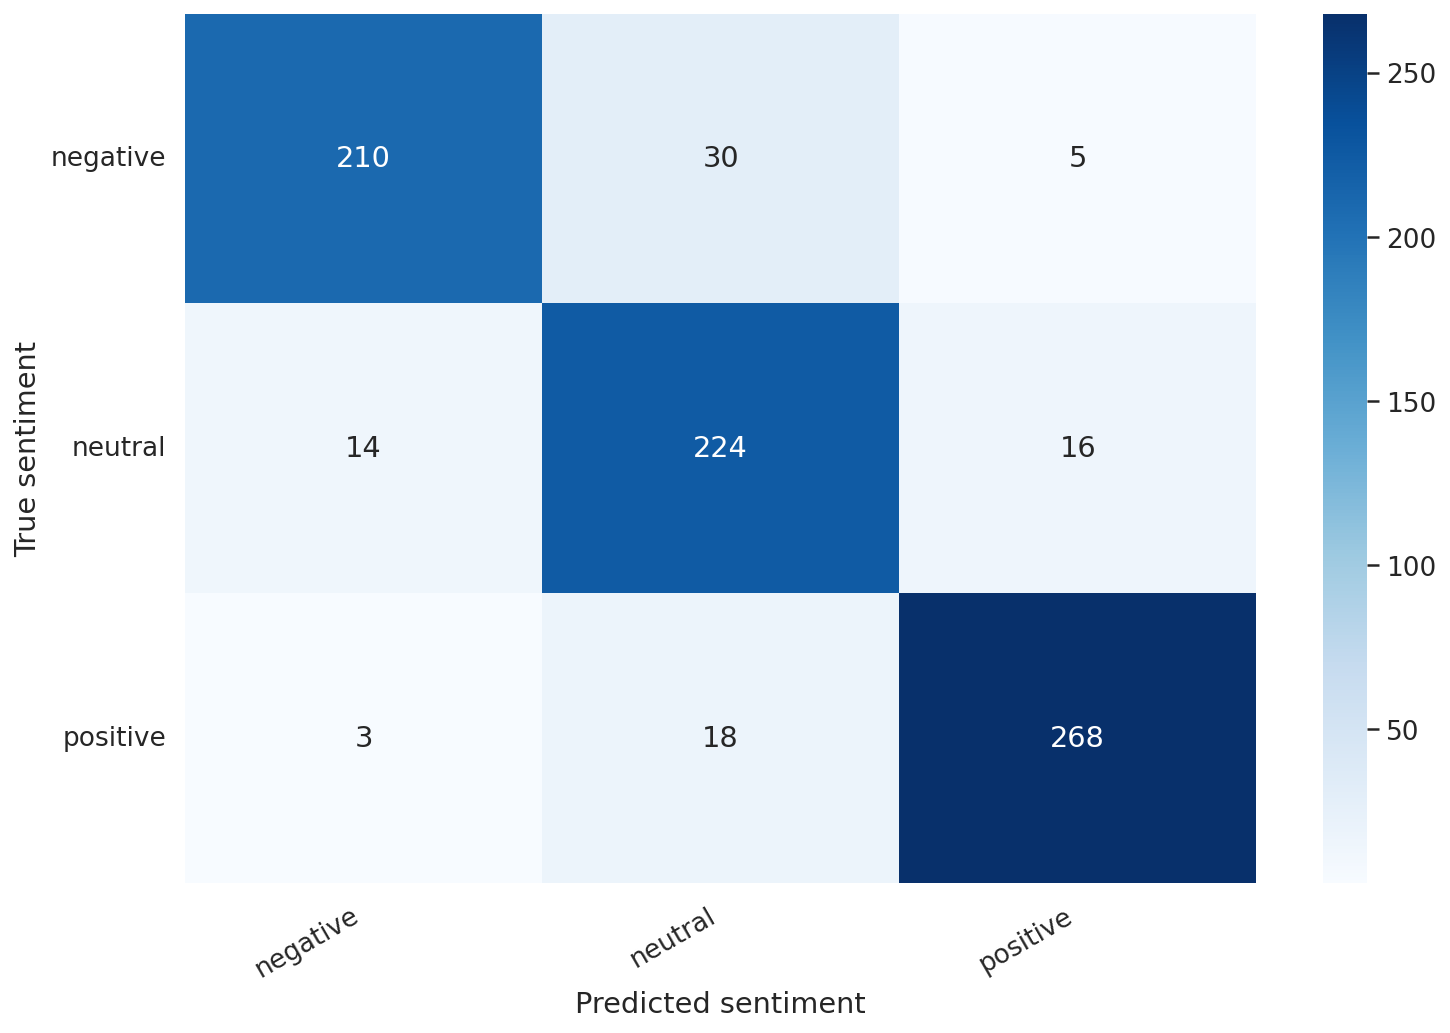

In [42]:
# As expected, 3 star (neutral) reviews are hard to classify
# But the model performs reasonably well
# Let's plot the confusion matrix

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')  
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')
    
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [43]:
# Thus we can see there is indeed some confusion on neutral reviews
# It confuses positive and neutral at roughly equal frequency
# That's a good performance overview, now let's look at an example from test data

idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': y_pred_probs[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f"True Sentiment: {class_names[true_sentiment]}")

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True Sentiment: neutral


(0.0, 1.0)

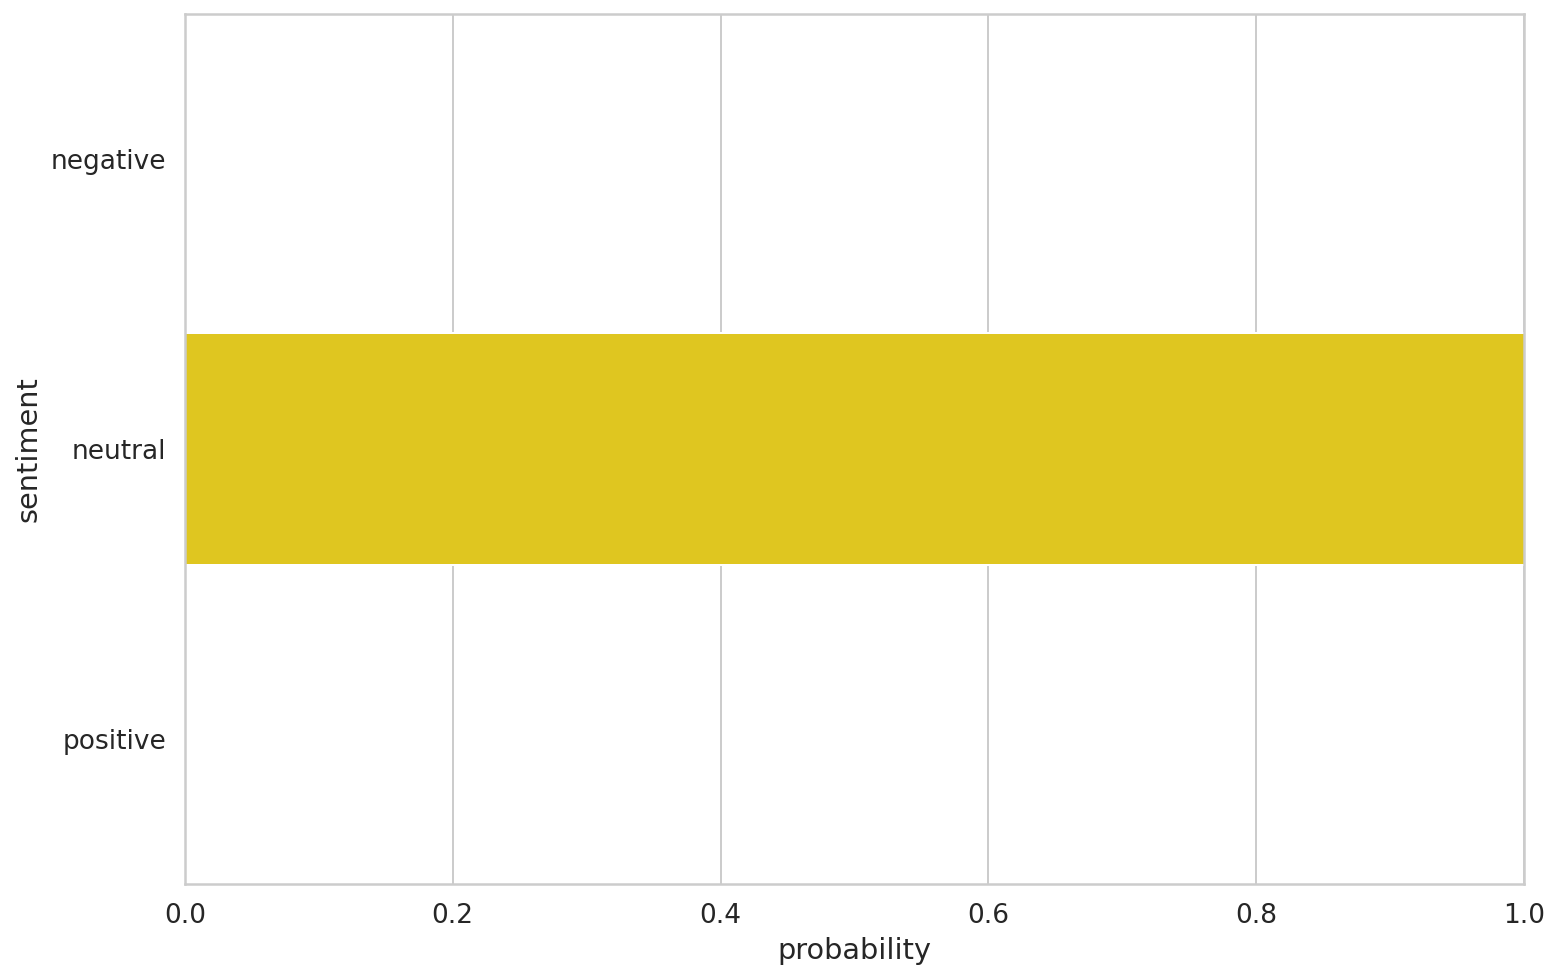

In [44]:
# We have an example review text as well as the true sentiment
# Now we can look at our model's confidence

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])

That's a 100% confidence correct guess! <br>
Now let's check out how we can use the model to predict the sentiment in raw text.

In [45]:
review_text = "I love learning NLP when amazing open source libraries and tools exist!!"

In [46]:
# Use the tokenizer to decode the text
encoded_review = tokenizer.encode_plus(
    review_text,
    truncation=True,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
)

In [47]:
# Now let's get the predictions
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review Text: {review_text}')
print(f'Predicted Sentiment: {class_names[prediction]}')

Review Text: I love learning NLP when amazing open source libraries and tools exist!!
Predicted Sentiment: positive


In [48]:
# Let's try and put this in a function so we can interactively 
def live_predict(review_text):
    encoded_review = tokenizer.encode_plus(
        review_text,
        truncation=True,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    # Now let's get the predictions
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    
    print(f'Predicted Sentiment: {class_names[prediction]}')
    
print("Interactive session started. Type 'quit' to stop.")
while True:
    review_text = input("Say something!")
    if review_text.lower() == "quit":
        print("Session ended")
        break
    live_predict(review_text)

Interactive session started. Type 'quit' to stop.


Say something! I really like BERT, it's great at what it does.


Predicted Sentiment: positive


Say something! After using PyTorch I find TensorFlow to be very bulky and unintuitive.


Predicted Sentiment: neutral


Say something! I think TensorFlow frankly needs serious improvement to compete with the ease of use of PyTorch


Predicted Sentiment: neutral


Say something! TensorFlow is really bad.


Predicted Sentiment: negative


Say something! Quit


Session ended


As we can see the bot does have a lot of trouble predicting neutral responses, but this is mostly due to the unbalanced data we ended up with. The model can be improved a lot with more balanced data. 